**WARNING: This work is currently under review. It's claims should be taken with caution. It is only available for interested folks to provide feedback (which is very wellcome!)**

## Abstract

It has been observed that [payments on the Lightning Network fail too often even if several attempts for the delivery of a payment are made](https://youtu.be/zk7hcJDQH-I?si=2k2pRtS5nAKaP92d). Most people believe that depletion of liquidity in channels is a challenge for payment delivery and route discovery. While [depletion can be explained through drain which can be mitigated through various control valves](https://blog.bitmex.com/the-power-of-htlc_maximum_msat-as-a-control-valve-for-better-flow-control-improved-reliability-and-lower-expected-payment-failure-rates-on-the-lightning-network/) there is [research in this repository showing that payment failure rates are expected to happen due to the statistical min cut distribution of all pairs of peers in the network](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/main/likelihood-of-payment-possability/An%20upper%20Bound%20for%20the%20Probability%20to%20be%20able%20to%20successfully%20conduct%20a%20Payment%20on%20the%20Lightning%20Network.ipynb) on the liquidity graph. That observation is independent of the drain in channels and the uncertainty about the liquidity that is part of the protocol.

This notebooks explains how the $2$-party channel design seems to be the main reason for the limited abilities to successfully facilitate payments at a service level objective that is close to $100\%$. 

We introduce a [geometric model](https://en.wikipedia.org/wiki/Algorithmic_Geometry) to study the impact of payment channels to the number of possible wealth distributions of Bitcoins between the users of the Lightning Network. This particular question is interesting because any payment between two peers can be considered as a change in the wealth distribution of the peers. Consequently, the more wealth distributions are possible in a fixed Lighting Network Topology the more payments can be facilitated. The problem of counting how many payments are possible in a given network topology is related to the computationally hard problem of [Counting Integer Flows in Networks](https://arxiv.org/abs/math/0303228). Thus we show that the number of possible wealth distributions can be described by the volume of a [convex polytope](https://en.wikipedia.org/wiki/Convex_polytope) that is defined by the Lightning Network's channel graph. While exact [computation of such volumes](https://en.wikipedia.org/wiki/Convex_volume_approximation) is also computationally challenging it is known that the volumes can be estimated well through [Monte Carlo Simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method). 

Besides the $2$-party channel design we show that the low densitiy of the network and the inequality of channel capacities reduces the ability of the network to facilitate payments. However the evidence demonstrated in this notebook suggests that the biggest limitation by far seems to be the two party channel design that is currently being deployed on the network. 

We give empirical evidence that the deployment of multiparty channels could allow for service level obejectives close to $100\%$ even if the network consists of less than $1$ multiparty channel per peer. Under the assumptions that multi party channels don't produce significantly more on chain footprint as the current channels this result would imply that off chain (multiparty) payment channel network could be supported with the given on chain bandwidth and be able to facilitate almost all payments without the necessity to conduct additional on chain transactions for liquidity management and realocation. 

In particular we show empirically that when extending the $2$-party channels of a current snapshot of the lighting network to $120$-party channel by randomly adding peers we observe that $100\%$ of our sampled wealth distributions were feasible in the multi party channel network where $\0\%$ of our sampled wealth distributions were feasible in the $2$-party channel design  

### Summary of our contributions in this notebook:

* A [Geometric model](https://en.wikipedia.org/wiki/Algorithmic_Geometry) based on convex polytopes to describe the space of wealth solutions that is given by channel graph
* A [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) based simulation to [estimate the volume of the convex polytopes](https://en.wikipedia.org/wiki/Convex_volume_approximation).
* An investigation how the topology of the network impacts the number of possible wealth distributions.
* An argument how the inquality of channel capacities reduces the number of possible wealth distributions
* A demonstration of how multi party channels allow for more wealth distributions and (potentially) less on chain transactions than the currently deployed 2 party channels.


### Acknowledgements: 

Thanks to Stefan Richter and [Christian Kümmerle](https://cci.charlotte.edu/directory/christian-kuemmerle/) for helpful discussions, insights and feedback while this work was being created. The work is sponsored through a [grant from OpenSats](https://opensats.org/blog/rene-pickhardt-receives-lts-grant) and through [individual patreons](https://www.patreon.com/renepickhardt).

In [1]:
#some libraries that are necessary
from drs import drs
import numpy as np
from math import comb
import random
from networkx.readwrite import json_graph
import json
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
from scipy.stats import zipf

## Modeling Wealth Distributions on the Bitcoin Network as a convex polytope

Let $w_1,\dots,w_n$ be the wealth of $n$ users, i.e. the number of coins each user owns. Given a fixed number $C$ of coins in circulation the possible wealth distributions may be described by a convex polytope. This is given as the intersection of the hyperplane derrived from the set of zeros of the equation $w_1 + \dots w_n = C$ with the [half spaces](https://en.wikipedia.org/wiki/Half-space_(geometry)) $w_i \geq 0$.

* The linear hyperplane $\{\vec{w} \in \mathbb{Z}^n|w_1 + \dots + w_n - C = 0\}$ describes the fact that all coins must be distributed among all users.
* The $n$ convex half spaces $\{\vec{w} \in \mathbb{Z}^n | w_i \geq 0\}_i$ describe the fact that none of the users may have negative wealth.

In particular it is trivial to see that by construction that the described geometric object is both **convex** and **bounded** which is why - in accordance to the literature we omit this two words but mean them when we speak of (convex) polytopes. 


***Disclaimer: While low dimensional observations in Geometry may not directly translate to higher dimensions we still use the first part of this notebook to introduce low dimensional examples to give some intuition about this new model of the Lighting Network*** 

We start by looking at a low dimensional example of $3$ users that own in total $12$ coins.


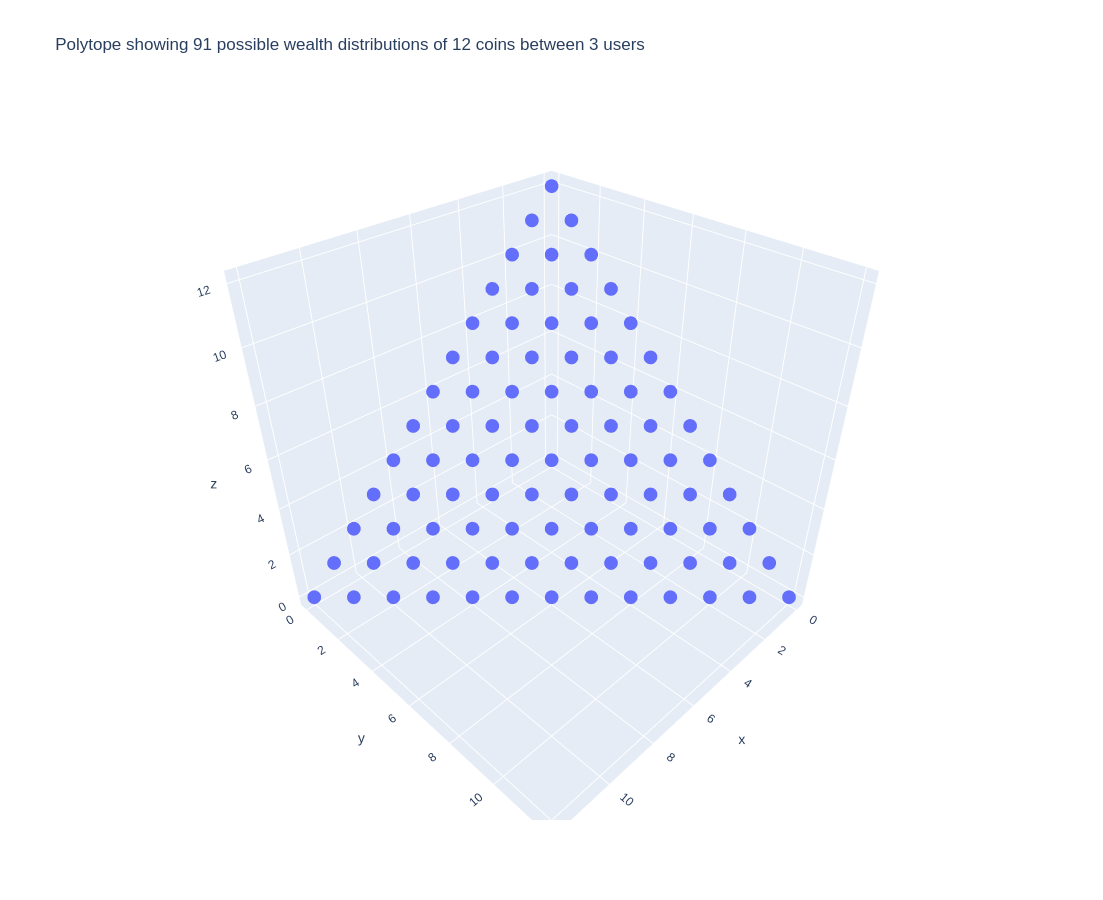

In [2]:
C = 12
data_x = []
data_y = []
data_z = []
count = 0
for z in np.arange(0, C+1):
    for x in np.arange(0, C+1):
        for y in np.arange(0, C+1):
            if x+y+z ==C:# Constraint given by the Bitcon Network (and assumption that all coins are distributed amont all users)
                data_x.append(x)
                data_y.append(y)
                data_z.append(z)
                count +=1
fig = px.scatter_3d(x=data_x, y=data_y, z=data_z,width=900, height=900,
                    title= "Polytope showing {} possible wealth distributions of {} coins between 3 users".format(count, C))
fig.show()


We note an analytical closed formular for the number of (blue) dots in this polytope is known. The number of integer solutions to the equation $w_1+\dots+w_n = C$ may be described by ${C+n-1 \choose n-1}$. If we compute the formular for $C=12$ and $n=3$ we get: ${12+3-1 \choose 3-1} = {14 \choose 2} = 91$. This can be computed with the following code:

In [3]:
C = 12
n = 3
print("{} wealth distributions for {} coins and {} users".format(comb(C+n-1, n-1), C, n))


91 wealth distributions for 12 coins and 3 users


The number of wealth distributions (i.e. the binomial coefficiant) grows quickly with the number $n$ of users splitting the $C$ coins. For example already for only 13 users there are more wealth distributions for 21 Mio coins (assuming a coin cannot be divided further) possible than there exist private keys when assuming $256$ bits of entropy.

In [4]:
C = 21_000_000
n = 13
print("{} wealth distributions for {} coins and {} users".format(comb(C+n-1, n-1), C, n))
print(2**256, "The size of the private key space")

15356639378818364227077318033318658555893632571113300037840723932299152640925001 wealth distributions for 21000000 coins and 13 users
115792089237316195423570985008687907853269984665640564039457584007913129639936 The size of the private key space


## Relation between wealth distributions and Bitcoin Payments (transactions): 

Making a Bitcoin transaction changes the wealth distribution. In particularly: Every wealth distribution can be achieved from every other wealth distribution with a finite series of Bitcoin Transactions. However at least 1 transaction (payment) is necessary to transition from one wealth distribution to another one. (In mathematical sophisticated language one could write that the [Bitcoin transactions are the Automorphisms of the Convex Polytope of of wealth distributions](https://en.wikipedia.org/wiki/Automorphism).)

A key use of money is to be able to facilitate payments (e.g. transfer wealth). If however the number of possible wealth distributions grows very quickly in comparison to the low bandwidth of transactions that the Bitcoin Network supports (due to technical limits of blockchain based distributed consensus systems), we could prematurely come to the conclusion that the bitcoin network might not be usable as a payment network or as electronic cash.

However offchain payment channel networks (e.g. the Lightning Network) have been suggested to address the problem. In the following we describe the geometry of such payment channel networks and try to understand if (and under what circumstances) they can deliver on their promise to facility payments. 

## Describing feasible wealth distributions of payment channel networks as convex sub polytopes

If peers collaboratively lift Bitcoins to payment channels through on chain transactions they can consequently achieve some wealth distributions without requiring additional onchain transactions to do so. 

The wealth distributions that are achievable off chain are described by a subpolytope that is realized by cutting the afore mentioned base polytope with half spaces that result from the following constraints: 

1. Sum of the wealth of two peers $w_i$ and $w_j$ of the channel has to be larger than the capacity $c_{ij}$ of the channel: $w_i + w_j \geq c_{ij}$.
2. The wealth $w_i$ of each user must not exceed the capacity of all the channels that the user is part of: $\sum_{j=1}^nc_{ij} \geq w_i$ (In particular $c_{ij}$ is assumed to be zero if no channel between user user $i$ and $j$ exists.

The first constraint is given because money in a channel is collaboratively owned by the peers that maintain the channel. While a peer can ask to change the state in the channel to route some sats to other peers the sats in the channel cannot leave the channel without conducting on chain operations.

### Example 1: 12 coins for 3 users in a fully connected Lighting Network
We go back to our example of distributing $12$ coins among $3$ users. Let us assume the coins where initially distributed in a way that every user was able to open and maintain a payment channel of capacity $4$ with every other user then we could observe the following sub polytope (in red color)


In [3]:
C=12 
data_x = []
data_y = []
data_z = []
colors = []
maxchan = (4,4,4)
for z in np.arange(0, C+1):
    for x in np.arange(0, C+1):
        for y in np.arange(0, C+1):
            if x+y+z ==C:# Constraint given by the Bitcon Network (and assumption that all coins are distributed amont all users)
                data_x.append(x)
                data_y.append(y)
                data_z.append(z)
                # test the assumptions given my the lightning network topology
                if x+y >= maxchan[0] and x+z >= maxchan[1] and y+z >= maxchan[2] and x <=8 and y <=8 and z <=8:
                    colors.append("LN")
                else:
                    colors.append("onchain")
ex1_ln = len([1 for x in colors if x == "LN"])
ex1_oc = len([1 for x in colors if x == "onchain"])                
fig = px.scatter_3d(x=data_x, y=data_y, z=data_z,color = colors, width=900, height=600,
                    title= "Wealth distributions on Bitcoin on Lighting Network for {} coins and channels of capacity {}, {} and {}".format(C,maxchan[0],maxchan[1],maxchan[2]))
fig.show()
print("{:4.2f}% of all welath distributions are possible on the Lighting Network with this particular topology".format((100.*ex1_ln)/(ex1_ln+ex1_oc)))

67.03% of all welath distributions are possible on the Lighting Network with this particular topology


In this small network that consists of a fully connected network topology between only $3$ peers we see that $61$ out of the $91$ wealth distributions are achievable without requiring further on chain transactions. Only if a user was to own $9$ or more coins the topology of the network would have to change and on chain transactions would need to be conducted. 

Being able to reach $67\%$ of all wealth distributions in this fixed topology without additional on chain operations seems like a strong improvement. However it is a particularity of the small size of the example. To see this we look at a second example in one dimension higher (the last one that is visible for the human eye) as we need to come back to it later in this work. 

### Example 2: 12 coins in a fully connected network of 4 users

In the following we study a network of $4$ participants with $12$ coins and $6$ channels that have a capacity of $2$ coins each. While the configuration space is $4$ dimensional there is a three dimensional embedding of the onchain and Lighting Network polytopes available which we describe and visualize here.

The polytope is parameterized by taking an feasbile wealth distribution (e.g: $(12,0,0,0)$) and add a linear combination that fulfills the constraints coming from the description of the polytops. Basis vectors could be those that remove a coin from user 1 and give it to each of the other users. 

$P(x,y,z) = (12,0,0,0) + x\cdot (-1,1,0,0) + y\cdot (-1,0,1,0) + z \cdot (-1,0,0,1)$

the tuples (x,y,z) that produce the wealth distributions that are feasible in the bitcoin network or the given lighting network with the selected topology produce the 3-dimensional embedding and can be visualized as follows: 

In [6]:
start = np.array([12,0,0,0])
b1 = np.array([-1,1,0,0])
b2 = np.array([-1,0,1,0])
b3 = np.array([-1,0,0,1])

data_x = []
data_y = []
data_z = []
colors = []

for x in range(13):
    for y in range(13):
        for z in range(13):
            r = start + x*b1 + y*b2 + z*b3 #find a vector
            if min(r)>=0 and max(r)<=12: #vector is a possible wealth distribution (assumptions from bitcoin)
                data_x.append(x)
                data_y.append(y)
                data_z.append(z)
                # Test the constraints of the Lightning Network
                if r[0]+r[1] >=2 and r[0]+r[1] >=2 and r[0]+r[3] >=2 and r[1]+r[2]>=2 and r[1]+r[3] >=2 and r[2] + r[3] >=2 and r[0] <=6 and r[1] <=6 and r[2] <=6 and r[3] <= 6:
                    colors.append("LN")
                else:
                    colors.append("onchain")

ex2_ln = len([1 for x in colors if x == "LN"])
ex2_oc = len([1 for x in colors if x == "onchain"])                
fig = px.scatter_3d(x=data_x, y=data_y, z=data_z,color = colors, width=1200, height=900,
                    title= "Wealth distributions on Bitcoin on Lighting Network for {} coins and channels of capacity {}, {} and {}".format(C,maxchan[0],maxchan[1],maxchan[2]))
fig.show()
print("{:4.2f}% of all welath distributions are possible on the Lighting Network with this particular topology".format((100.*ex2_ln)/(ex2_ln+ex2_oc)))

45.27% of all welath distributions are possible on the Lighting Network with this particular topology


We see that with the given fixed topology for $4$ users the relative number of feasible wealth distributions drops to $45\%$ of all wealth distributions. We would like to investigate higher dimensions (aka networks with more users). Unfortunatelly we couldn't find a closed analytic expression for the number of red dots. 

As we have seen the polytopes grow quickly with the number of coins and users. Thus it is practically impossible to list all possible wealth distributions and count the integer solutions. 


## Monte Carlo Simulation to compute the volume of the sub polytope 

Instead of computing the number of red dots we randomly select points on the blue polytope (which defines all possible wealth distributions) and count how often the sampled wealth distributions would have been feasible in a configuration of the Lighting Network (the red dots). If the points in the base polytope are sampled uniformly then this should give an approximation to the volume of the polytope defined by the Lighting Nework. 

### Uniformly sampling Bitcoin Wealth distributions

Sampeling uniformly distributed points in this high dimensional polytope is non trivial but has been solved with [matlab code available here](https://www.mathworks.com/matlabcentral/fileexchange/9700-random-vectors-with-fixed-sum). This has been generalized (known as the [Dirichlet rescale algorithm](https://sigbed.org/2020/12/21/the-dirichlet-rescale-drs-algorithm-a-general-purpose-method-underpinning-synthetic-task-set-generation/) for which a [python implementation exists](https://pypi.org/project/drs/).

While coins are integers we embed our polytopes and constraints into $\mathbb{R}^n$ as volume computations in $\mathbb{R}^n$ are easier to approximate via statistical sampling.  

In [90]:
#example usage of the DRS lib
print("we find a possible distribution of 21Million Bitcoin among five users:")
w1, w2, w3, w4, w5 = drs(5,21_000_000)
print("{:.8f} + {:.8f} + {:.8f} + {:.8f} + {:.8f} = {}\n".format(w1, w2, w3, w4, w5, int(w1+w2+w3+w4+w5)))

print("More readable we distribute 15 coins among 3 users:")
w1, w2, w3 = drs(3,15)
print("{:.2f} + {:.2f} + {:.2f} = {}".format(w1, w2, w3, int(w1+w2+w3)))


we find a possible distribution of 21Million Bitcoin among five users:
4159192.71867946 + 6396860.69518352 + 1676043.72525344 + 8610561.35517646 + 157341.50570711 = 21000000

More readable we distribute 15 coins among 3 users:
9.49 + 2.27 + 3.24 = 15


For the Monte Carlo Simulation we define the following three helper function. `evaluate_possible_wealth_distributions` is the main API call that we use through the reminder of the notebook. For a provided number of users, and coins and a given topology it conducts the test against uniformly distributed wealth distributions and thus estimates the volume of the polytope that is given through the network topology 

In [8]:
def max_wealth_of_users(channels, num_users):
    """
    computes the maximum wealth each user can have with respect to all existing payment channels
    This is equivalent to the total capacity that all channels the user is member of have.
    """
    max_wealth = {i:0 for i in range(num_users)}
    for channel, cap in channels.items():
        for user in channel:
            max_wealth[user]+=cap
    return max_wealth

def test(wealth_distribution, multi_party_channels, max_wealth):
    """
    We test weather a wealth distribution is possible given the constraints from the channels
    """
    for i, wealth in enumerate(wealth_distribution):
        if wealth > max_wealth[i]++0.0000000001:
            #print(wealth, max_wealth[i], max_wealth, multi_party_channels)
            return False
    for users,cap in multi_party_channels.items():
        s = 0
        for user in users:
            s += wealth_distribution[user]
        if s + +0.0000000001 < cap:
            #print(sum([wealth_distribution[user] for user in users]), cap)
            return False
    return True

def evaluate_possible_wealth_distributions(num_users, num_coins, channels, number_of_runs = 1_000):
    possible = 0
    max_wealth = max_wealth_of_users(channels, num_users) #the maximum wealth each user can have in the toplogy of our toy example
    #print(max_wealth)
    for i in range(number_of_runs):
        wealth_distribution = drs(num_users,num_coins)
        if test(wealth_distribution, channels, max_wealth):
            possible+=1
    return float(possible)/number_of_runs


## Comparing the Results of the Monte Carlo simulation with the exact computation

As we have exact results in low dimensions we test that the monte carlo simulation in deed produces approximations that are close to the exactly computed volumes

In [9]:
num_users = 3
num_coins = 12
channels = {(0,1):4, (0,2):4, (1,2):4} #create three channels with capacity 3 each


volume = evaluate_possible_wealth_distributions(num_users, num_coins, channels)
print("Monte carlo says {:4.2f}% of all distributions are possible. The exact result (fraction of red dots) says: {:4.2f}%".format(volume*100., (100.*ex1_ln)/(ex1_ln+ex1_oc)))

num_users = 4
num_coins = 12
channels = {(0,1):2, (0,2):2, (1,2):2,(0,3):2, (1,3):2, (2,3):2} #create three channels with capacity 3 each
volume = evaluate_possible_wealth_distributions(num_users, num_coins, channels)
print("Monte carlo says {:4.2f}% of all distributions are possible. The exact result (fraction of red dots) says: {:4.2f}%".format(volume*100., (100.*ex2_ln)/(ex2_ln+ex2_oc)))


Monte carlo says 67.60% of all distributions are possible. The exact result (fraction of red dots) says: 67.03%
Monte carlo says 45.50% of all distributions are possible. The exact result (fraction of red dots) says: 45.27%


We see that the result of the Monte carlo Simulation is within the range of the exact computation. Of course this only annecdotal evidence that the Monte Carlo Simulation and statistical process works as intended. However in particular for the volume of polytopes there is plenty of research indicating that Monte Carlo Simulation is indeed a sane method to approximate the volume rather accurately.


## Higher dimensional experiments (properties of networks with more peers)

We want to investigate how many payments (aka various wealth distributions) are possible if more users join the off chain network. 

We start on a network with $21$ Mio coins and compute the sizes of the polytopes of fully connected networks with more and more users to see if the low dimensional trend of declining volumes continues. 

First we need a helper function to create payment channels in our simulated test networks

In [72]:
def generate_multi_party_channels(num_coins, num_users, num_channels, party_size=2, equal_capacity = False,zipf_dist=False):
    """
    generates @num_channels channels with a @num_coins total capacity between @num_users.

    Optionally the channels may be multi party channels which we need for later considerations
    In particular the capacities of the channels may be uniformly or zipf distributed of or equal capacity
    """
    res = dict()
    capacities = []
    if zipf_dist:
        a=1.01
        k = np.arange(num_channels+1)
        zipf.pmf(k, a)
        capacities = [num_coins*x for x in zipf.pmf(k,a)[1:]]
        #print(capacities[0],capacities[-1])
    else:
        if equal_capacity: 
            capacities = [num_coins/num_channels for i in range(num_channels)]
        else:
            capacities = drs(num_channels,num_coins)
    cnt = 0
    #FIXME: very inefficient for dense networks!
    while len(res) < num_channels:
        t = tuple(sorted(random.sample(range(num_users), party_size)))
        if t not in res:
            res[t] = capacities[cnt]
            cnt+=1
    return res


We compute the volumes of the polytops of Lightning networks with $k$ users. In the first case our networks are fully connected. In the second case only half of the channels (obviously with increased capacity) are added to the network. 

In [25]:
num_coins = 21_000_000

users = []
volumes = []
for num_users in range(3,41):
    channels = generate_multi_party_channels(num_coins,num_users, comb(num_users,2),equal_capacity=True)
    #print("generated channels")
    #print(channels)
    users.append(num_users)
    volumes.append(evaluate_possible_wealth_distributions(num_users, num_coins, channels,100_000))
    
plt.figure(figsize=(12,9))
plt.title("Possible wealth distributions depending on the number of users on LN")

#data series 1: fully connected network
users = []
volumes = []
for num_users in range(3,31):
    channels = generate_multi_party_channels(num_coins,num_users, comb(num_users,2),equal_capacity=True)
    users.append(num_users)
    volumes.append(evaluate_possible_wealth_distributions(num_users, num_coins, channels,100_000))
plt.scatter(users, volumes,label="fully connected network")

#data series 2: Network with lower connectivity by taking only 50% of the payment channels of a full network
users = []
volumes = []
for num_users in range(3,31):
    channels = generate_multi_party_channels(num_coins,num_users, max(2,int(comb(num_users,2)/2)),equal_capacity=True)
    users.append(num_users)
    volumes.append(evaluate_possible_wealth_distributions(num_users, num_coins, channels,100_000))
plt.scatter(users, volumes,label="halv connected network")

plt.plot([x for x in range(2,31)], [1.8*1.375**-x for x in range(2,31)],label="$f(x)=1.8*1.375^{-x}$")
plt.grid()
plt.xlabel("number of participants")
plt.ylabel("relative volume of polytope encoding possible wealth distributions")
#plt.xscale("log")
plt.legend()
plt.yscale("log")
plt.show()

While the number of possible wealth distributions also grows exponentially with users joining the Bitcoin network the relative number of achievable wealth distributions on the lightning network declines exponentially with more users joining the lighting network. 

**This means even with optimal routing, payment planning and liquidity finding strategies certain payments (changes in the wealth distribution) won´t be possible without on chain transactions.**

Let us illustrate what this fit means for a reasonable network

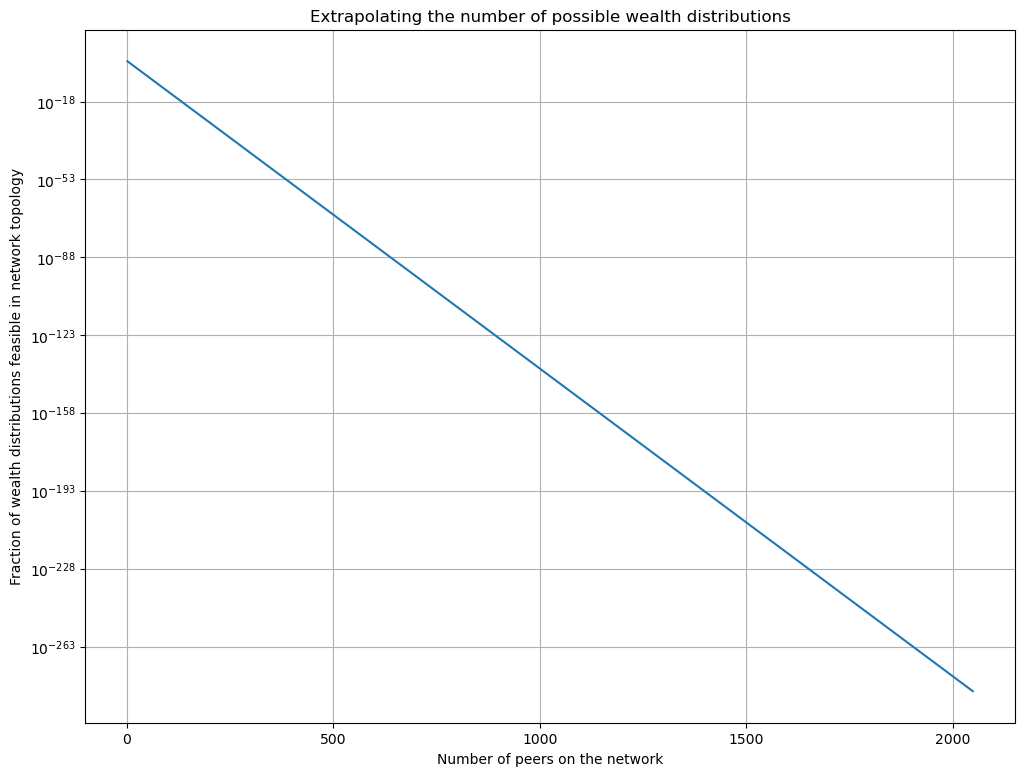

In [28]:
plt.figure(figsize=(12,9))
plt.title("Extrapolating the number of possible wealth distributions")
plt.plot([2**i for i in range(12)],[1.8*1.375**-(2**i) for i in range(12)])
plt.yscale("log")
plt.grid()
plt.xlabel("Number of peers on the network")
plt.ylabel("Fraction of wealth distributions feasible in network topology")
plt.show()


Obviously a fully connected network with channels of equal size is also from the perspective of consuming on chain resources not desireable. (Without formal proof) we will provide evidence that from a perspective of maximizing the number of feasible wealth distributions this topoloy seems optimal. But even in that topology additional onchain transactions to conduct payments are undesireble. 

Before doing so we note that this result so far provides insight why a vast majority of payments on the network are not feasible. (many of which will not even be attempted by users, as a user will not attempt to create an invoice to receive $10$ BTC if she only has for example $1$ BTC of inbound liquidity. 

## Investigating different topologies

Staying on small networks we want to see the impact of various topologies to the network's ability to facilitate payments. Thus we run various Monte carlo simulations on networks that are not fully connected and we also select the capacities to be either of random size (in the first experiment) or of equal size (the second experiment and the afore mentioned examples)





In [83]:
print("Test Networks among 5 users with various chanal capacities and random channel sizes")
num_coins = 20
num_users = 5
experiment1_data = []
for num_channels in range(3,11):
    channels = generate_multi_party_channels(num_coins,num_users, num_channels)
    experiment1_data.append(np.array([100*evaluate_possible_wealth_distributions(num_users, num_coins, channels,500) for i in range(500)]))
    print("average: {:4.2f}% of wealth distributions possible on {:2} channels.".format(np.mean(experiment1_data[-1]), num_channels))

print("\nChecking Networks with random channels but equal capcity")
experiment2_data = []
for num_channels in range(3,11):
    channels = generate_multi_party_channels(num_coins,num_users, num_channels,equal_capacity =True)
    experiment2_data.append(np.array([100*evaluate_possible_wealth_distributions(num_users, num_coins, channels,100) for i in range(500)]))
    print("average: {:4.2f}% of wealth distributions possible on {:2} channels.".format(np.mean(experiment2_data[-1]), num_channels))


Test Networks among 5 users with various chanal capacities and random channel sizes
average: 0.00% of wealth distributions possible on  3 channels.
average: 0.50% of wealth distributions possible on  4 channels.
average: 2.96% of wealth distributions possible on  5 channels.
average: 6.27% of wealth distributions possible on  6 channels.
average: 16.95% of wealth distributions possible on  7 channels.
average: 20.09% of wealth distributions possible on  8 channels.
average: 16.37% of wealth distributions possible on  9 channels.
average: 25.74% of wealth distributions possible on 10 channels.

Checking Networks with random channels but equal capcity
average: 0.00% of wealth distributions possible on  3 channels.
average: 11.75% of wealth distributions possible on  4 channels.
average: 13.50% of wealth distributions possible on  5 channels.
average: 17.94% of wealth distributions possible on  6 channels.
average: 27.55% of wealth distributions possible on  7 channels.
average: 25.83% of

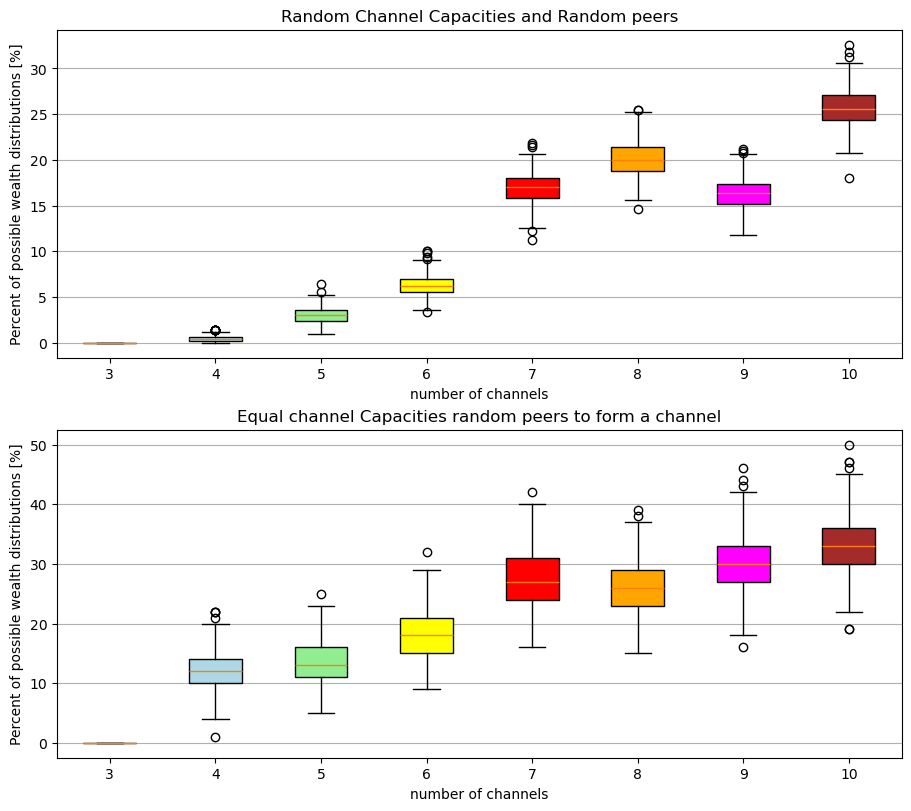

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 8),constrained_layout=True)
labels = ['3', '4', '5','6', '7', '8','9','10']
# rectangular box plot
bplot1 = ax1.boxplot(experiment1_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Random Channel Capacities and Random peers')

bplot2 = ax2.boxplot(experiment2_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Equal channel Capacities random peers to form a channel')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen','yellow', 'red', 'orange','magenta', 'brown',]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('number of channels')
    ax.set_ylabel('Percent of possible wealth distributions [%]')

plt.show()

We observe that the denser the network (indicated through more payment channels) the more wealth distributions seem to be achievable. Also the curve grows higher if the channels are all of equal capacity. We want to investigate the later observation a bit further. Thus we generate various fully connected channel graphs and compute the volume of the polytope as well as the [gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) (measureing the inequality) of the capacities 

In [86]:
#CC-BY-SA Attrib: Warren Weckesser via https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [87]:
num_coins = 20
num_users = 4
num_channels = 6
percentages = []
ginis = []
for i in range(1500):
    channels = generate_multi_party_channels(num_coins,num_users, num_channels)
    ginis.append(gini(list(channels.values())))
    percentages.append(100*evaluate_possible_wealth_distributions(num_users, num_coins, channels,5000))    



-0.9264275432639719 0.0


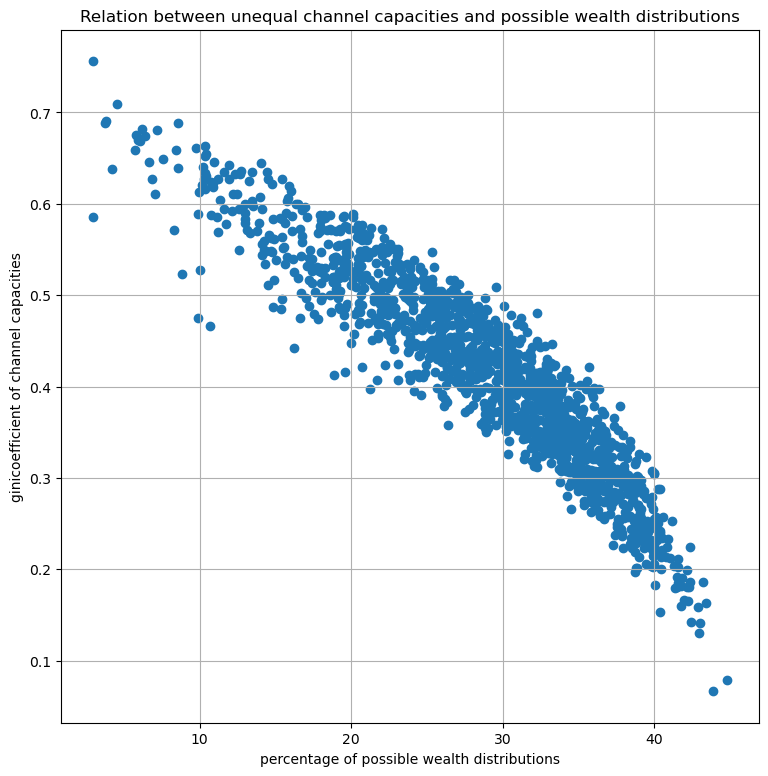

In [88]:
r, p = scipy.stats.pearsonr(ginis, percentages)
print(r,p)
plt.figure(figsize=(9,9))
plt.title("Relation between unequal channel capacities and possible wealth distributions")
plt.scatter(percentages, ginis)
plt.grid()
plt.xlabel("percentage of possible wealth distributions")
plt.ylabel("ginicoefficient of channel capacities")
plt.show()

-0.8495408210411747 0.0


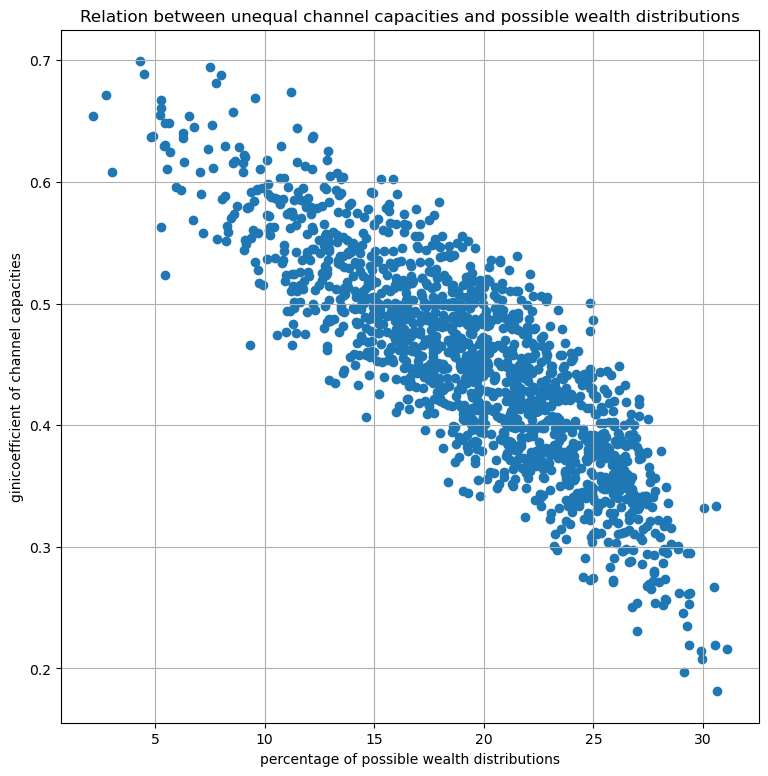

In [89]:
num_coins = 20
num_users = 5
num_channels = 10
percentages = []
ginis = []
for i in range(1500):
    channels = generate_multi_party_channels(num_coins,num_users, num_channels)
    ginis.append(gini(list(channels.values())))
    percentages.append(100*evaluate_possible_wealth_distributions(num_users, num_coins, channels,5000))    

r, p = scipy.stats.pearsonr(ginis, percentages)
print(r,p)
plt.figure(figsize=(9,9))
plt.title("Relation between unequal channel capacities and possible wealth distributions")
plt.scatter(percentages, ginis)
plt.grid()
plt.xlabel("percentage of possible wealth distributions")
plt.ylabel("ginicoefficient of channel capacities")
plt.show()


In fact we see that higher gini coefficients of the channel capacities (which indicate a bigger inequality of the capacities) seem to allow for fewer wealth distributions.

## Consequences on an observed Lighting Network snapshot
We see have seen that already for a network of $16k = 2^{14}$ nodes the relative volume of possible wealth distributions within a payment channel network is negligible in comparison to the theoretical number of possible wealth distributions that are achievable through on chain payments. 

If the above theoretical observations are true we should not be able to sample a single wealth distribution that is feasible on the actual observed Lighting Network even if as many as $100k$ randomly sampled wealth distributions were to be tested. 

In practice this means that random payments with random amounts (not the 10k to 100k sats payments that people are currently doing) will almost certainly not be feasible on the given network topology.

In order to test our hypothesis we start by importing a Lightning Network snapshot to also be able to conduct some experiments on realistic data and network topologies that we have observed in practicse. We took the snapshot from [Elias Roher's discharged-pc-data](https://git.tu-berlin.de/rohrer/discharged-pc-data/) rpository and adopted [his source code to load the data set](https://git.tu-berlin.de/rohrer/discharged-pc-data/-/blob/master/eval_scripts/main.py).


In [30]:
def load_json(file_path):
    try:
        f = open(file_path, 'r', encoding="utf8")
    except:
        print("Could not open file: " + file_path)
        return
    try:
        json_data =json.load(f)
    except:
        print("Could not parse JSON!")
        return
    for item in json_data['edges']:
        if item['capacity']:
            item['capacity'] = int(item['capacity'])

    return json_data

def load_graph(json_data):
    G = json_graph.node_link_graph(json_data, True, False, source="node1_pub", target="node2_pub", name="pub_key", key="channel_id", link="edges")
    return G

json_data = load_json("lngraph_2021_11_25__15_02.json")
G = load_graph(json_data)    


Use the data to compute some statistics about the used data set

In [93]:
total_coins = 0
ids = []
for edge in G.edges(data=True):
    total_coins += edge[2]["capacity"]

#we create an integer index for the node_ids as vectors in our polytope can more easily be addressed through this mapping
node_ids = list(G.nodes())
index = {node:i for i,node in enumerate(node_ids)}

ln_channels = dict()
for edge in G.edges(data = True):
    channel = tuple(sorted([index[edge[0]],index[edge[1]]]))
    ln_channels[channel] =  edge[2]["capacity"]

#we create the cpacities dictionary to quickly check the constraints of the polytope and decide member s
capacities = {index[node]:{} for node in node_ids}
for edge in G.edges(data=True):
    capacities[index[edge[0]]][index[edge[1]]]= edge[2]["capacity"]
    capacities[index[edge[1]]][index[edge[0]]]= edge[2]["capacity"]

max_wealth_per_node = {i:sum(capacities[i].values()) for i,n in enumerate(node_ids)}

print("Number of sats: {} ({} BTC) for {} nodes and {} channels".format(total_coins,int(total_coins/100_000_000), len(node_ids), len(G.edges())))

Number of sats: 278416182448 (2784 BTC) for 18288 nodes and 76540 channels


In [655]:
number_of_runs = 10_000
possible = 0
num_users = len(max_wealth_per_node)
num_coins = sum(ln_channels.values())
for i in range(number_of_runs):
    wealth_distribution = drs(num_users,num_coins)
    if test(wealth_distribution, ln_channels, max_wealth_per_node):
        possible+=1
        print("The very unlikely case occured that a sampled wealth distribution was fesible on the Lighting Network")

print(possible, "# of sampled wealth distributions where feasible on the Lighting Network\n\n")

if possible == 0:
    print("As expected none of the sampled wealth distributions was feasible with the observed Lighting Network topology.")

0 # of sampled wealth distributions where feasible on the Lighting Network


As expected none of the sampled wealth distributions was feasible with the observed Lighting Network topology.


 This results does however only reflect the mathematics of the currently implemented protocol that is based on two party channels. If we look at the constraints that reduce the size of the polytopes one comes to realize that implementing multi party channels weakens the constraints and should allow for larger sub polytopes. 

## Impact of allowing more users in (multi party) payment channels 

Looking at the constraints to the sub polytope one realizes that increasing the number of members in a channel weakens the constraints quite a bit. To illustrate this we go back to our example of $12$ coins for $4$ users and a fully connected network of $6$ channels that all have a capacity of $2$. If we look at three party channels (and assume again a fully connected network) we have $4$ channels of capacity $3$ each. Every user can no own up to $9$ coins and not only $6$. This may not sound like a huge improvement. However plotting the polytope one makes a first surprising observation with respect to it's volume (i.e.: number of possible wealth distributions (aka number of possible payments))

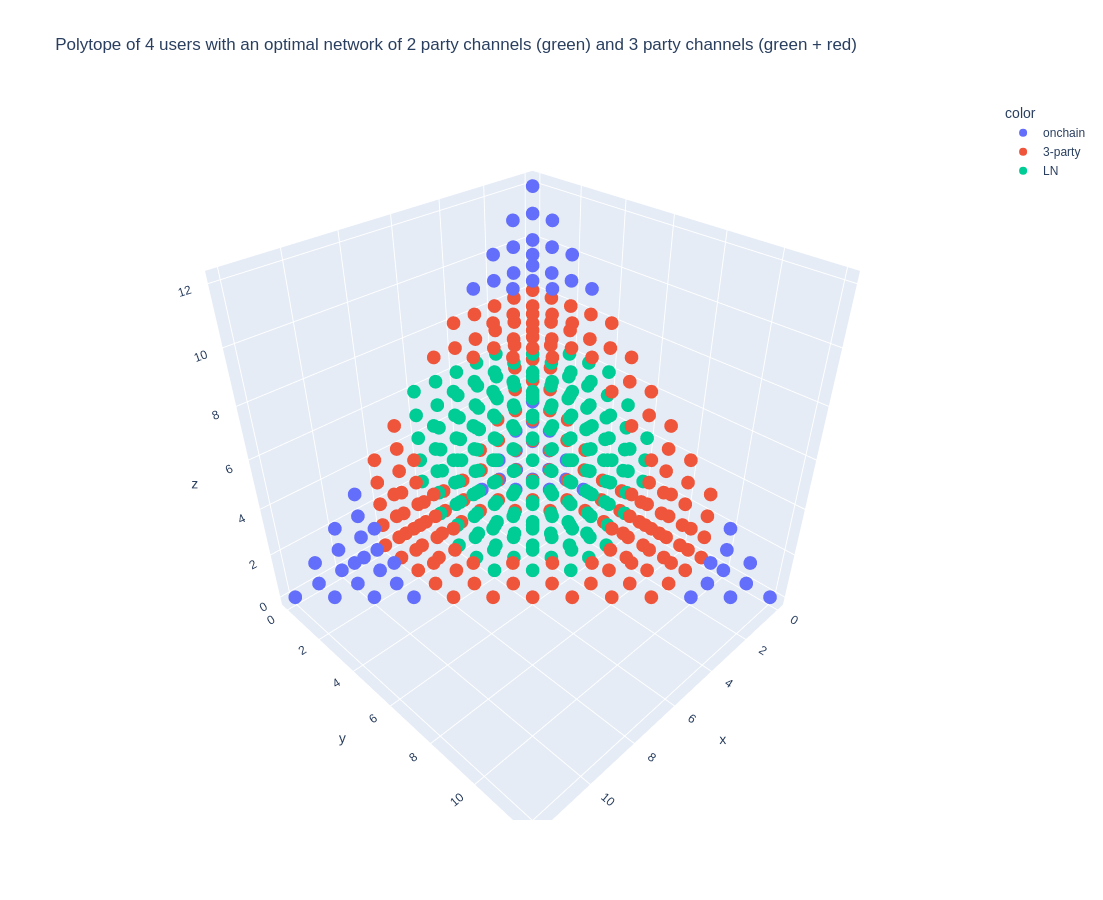

84.62% of all welath distributions are possible with 4 3-party channels of capacity 3
45.27% of all welath distributions are possible with 6 channels of capacity 2


In [4]:
start = np.array([12,0,0,0])
b1 = np.array([-1,1,0,0])
b2 = np.array([-1,0,1,0])
b3 = np.array([-1,0,0,1])

data_x = []
data_y = []
data_z = []
colors = []

for x in range(13):
    for y in range(13):
        for z in range(13):
            r = start + x*b1 + y*b2 + z*b3 #find a vector
            if min(r)>=0 and max(r)<=12: #vector is a possible wealth distribution
                data_x.append(x)
                data_y.append(y)
                data_z.append(z)
                if r[0]+r[1] >=2 and r[0]+r[1] >=2 and r[0]+r[3] >=2 and r[1]+r[2]>=2 and r[1]+r[3] >=2 and r[2] + r[3] >=2 and r[0] <=6 and r[1] <=6 and r[2] <=6 and r[3] <= 6:
                    colors.append("LN")
                elif r[0]+r[1]+r[2] >=3 and r[0]+r[1]+r[3] >= 3 and r[0]+r[2]+r[3] >=3 and r[1]+r[2]+r[3] >=3 and r[0] <=8 and r[1] <=8 and r[2] <=9 and r[3] <= 8:
                    colors.append("3-party")
                else:
                    colors.append("onchain")

ln = len([1 for x in colors if x == "LN"])
oc = len([1 for x in colors if x == "onchain"])                
multi = len([1 for x in colors if x == "3-party"])
fig = px.scatter_3d(x=data_x, y=data_y, z=data_z,color = colors, width=1200, height=900,
                    title= "Polytope of 4 users with an optimal network of 2 party channels (green) and 3 party channels (green + red)")
fig.show()
print("{:4.2f}% of all welath distributions are possible with 4 3-party channels of capacity 3".format((100.*(ln+multi))/(ln+multi+oc)))
print("{:4.2f}% of all welath distributions are possible with 6 channels of capacity 2".format((100.*ln)/(ln+multi+oc)))


We see that the (exponentially with more users declining) relative volume of the Lightning Network allowed for only $45\%$ of all theoretically possible wealth distributions. However the relative volume of the polytope that rises from a network that conists of 3-party channels covers $91\%$ of the volume of all theoretically possible wealth distributions. 

We believe this is a bit counter intuitive if one considers the relatively small increas in maximum wealth users could have. Also one could wonder if this just an articact of low diminsions and working because we could build a full network of 3 party channels. We note that for more users a full network of $3$ party channels has ${n \choose 3}$ channels and a fully connected network with $k$-party channels has ${n \choose k}$ channels. Those binomial coefficients grow considerably larger than the network of $2$ party channels which we already stated would not fit into the on chain capacities of the Bitcoin Network. 

In the following we investigate the actual behavior of multiparty channels and show that even for relatively small values of $k$ (in the range between $10$ and $100$ we need less channels than we have participants in the network for the relative volume of the polytope to be close too $100\%$. This result is in accordance with the theory of hypergraphs and expectable. (TODO: add reference)

In [76]:
num_coins = 2700*100_000_000 #number of coins deployd to a recent LN snapshot
num_users = 18200  #number of users on a recent Lighting network Snapshot
runs  = 100

volumes = []
party_sizes = []
num_channels = 80000 #number of channel on a recent Lighting network snapshot
for party_size in range(2,30):

    multi_party_channels = generate_multi_party_channels(num_coins, num_users, num_channels, party_size, equal_capacity=True)
    volume = evaluate_possible_wealth_distributions(num_users, num_coins, multi_party_channels,runs)
    volumes.append(volume)
    party_sizes.append(party_size)
    #print("party_size: {} allows for {:4.2f}% of all tested wealth distributions were possible".format(party_size, 100.0*volume))
    print(party_size,end=", ")
print("done")


2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, done


In [77]:
volumes1 = []
party_sizes1 = []
num_channels = 80000 #number of channel on a recent Lighting network snapshot
for party_size in range(2,30):
    multi_party_channels = generate_multi_party_channels(num_coins, num_users, num_channels, party_size)
    volume = evaluate_possible_wealth_distributions(num_users, num_coins, multi_party_channels,runs)
    volumes1.append(volume)
    party_sizes1.append(party_size)
    print(party_size,end=", ")
print("done")

2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, done


In [66]:
volumes2 = []
party_sizes2 = []
num_channels = 18200 #number of channel on a recent Lighting network snapshot
for party_size in range(2,30):
    multi_party_channels = generate_multi_party_channels(num_coins, num_users, num_channels, party_size)
    volume = evaluate_possible_wealth_distributions(num_users, num_coins, multi_party_channels,runs)
    volumes2.append(volume)
    party_sizes2.append(party_size)
#    print("party_size: {} allows for {:4.2f}% of all tested wealth distributions were possible".format(party_size, 100.0*volume))
    print(party_size,end=", ")

print("done")

2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, done


In [67]:
volumes3 = []
party_sizes3 = []
num_channels = 18200 #number of channel on a recent Lighting network snapshot
for party_size in range(2,30):
    multi_party_channels = generate_multi_party_channels(num_coins, num_users, num_channels, party_size, equal_capacity=True)
    volume = evaluate_possible_wealth_distributions(num_users, num_coins, multi_party_channels,runs)
    volumes3.append(volume)
    party_sizes3.append(party_size)
#    print("party_size: {} allows for {:4.2f}% of all tested wealth distributions were possible".format(party_size, 100.0*volume))
    print(party_size,end=", ")
print("done")

2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, done


In [73]:
volumes4 = []
party_sizes4 = []
num_channels = 18200 #number of channel on a recent Lighting network snapshot
for party_size in range(2,300,10):
    multi_party_channels = generate_multi_party_channels(num_coins, num_users, num_channels, party_size, zipf_dist=True)
    volume = evaluate_possible_wealth_distributions(num_users, num_coins, multi_party_channels,runs)
    volumes4.append(volume)
    party_sizes4.append(party_size)
#    print("party_size: {} allows for {:4.2f}% of all tested wealth distributions were possible".format(party_size, 100.0*volume))
    print(party_size,end=", ")
print("done")

2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252, 262, 272, 282, 292, done


In [ ]:
volumes5 = []
party_sizes5 = []
num_channels = 80000 #number of channel on a recent Lighting network snapshot
for party_size in range(2,300,10):
    multi_party_channels = generate_multi_party_channels(num_coins, num_users, num_channels, party_size, zipf_dist=True)
    volume = evaluate_possible_wealth_distributions(num_users, num_coins, multi_party_channels,runs)
    volumes5.append(volume)
    party_sizes5.append(party_size)
#    print("party_size: {} allows for {:4.2f}% of all tested wealth distributions were possible".format(party_size, 100.0*volume))
    print(party_size,end=", ")
print("done")

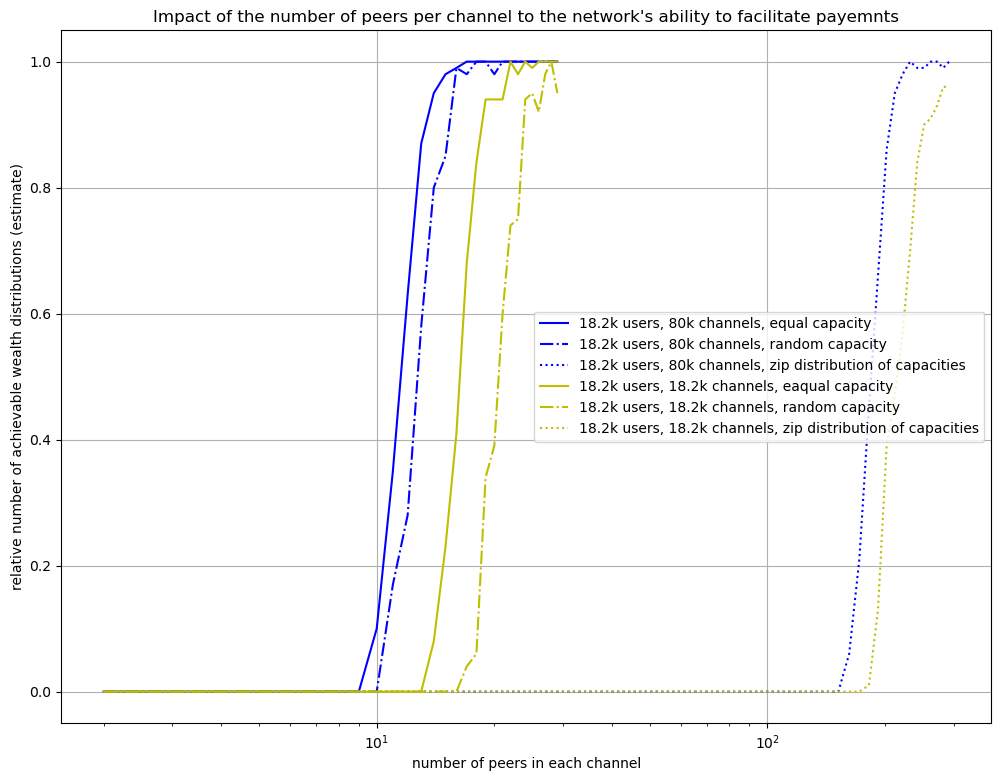

In [78]:
plt.figure(figsize=(12,9))
plt.title("Impact of the number of peers per channel to the network's ability to facilitate payemnts")
plt.plot(party_sizes,volumes, "b-",label="18.2k users, 80k channels, equal capacity")
plt.plot(party_sizes1,volumes1,"b-.", label="18.2k users, 80k channels, random capacity")
plt.plot(party_sizes5,volumes5,"b:", label="18.2k users, 80k channels, zip distribution of capacities")

plt.plot(party_sizes3,volumes3, "y-", label="18.2k users, 18.2k channels, eaqual capacity")
plt.plot(party_sizes2,volumes2, "y-.",label="18.2k users, 18.2k channels, random capacity")
plt.plot(party_sizes4,volumes4,"y:", label="18.2k users, 18.2k channels, zip distribution of capacities")
plt.xscale("log")
plt.grid()
plt.xlabel("number of peers in each channel")
plt.ylabel("relative number of achievable wealth distributions (estimate)")
plt.legend()
plt.show()

## Experiment on a Lighting Network Snapshot. 

Assuming our theory is correct we should observe on a snapshot of the lighting network the following: 

If we extend all channels to multiparty channels by randomly adding more peers to the existing channels then for a certain size of the multi party more than $99.999/%$ of the tested wealth distributions should be feasible in the network of multiparty channels.

In [62]:
volumes_ln = []
party_sizes_ln = []
for party_size in range(10,150,10):
    num_users = len(G)
    extended_ln_channels = {}
    for chan,cap in ln_channels.items():
        users = [x for x in random.sample(range(num_users), party_size)]
        #even if a collision should occure than this channel has just a smaller party
        users.append(chan[0])
        users.append(chan[1])
        t = tuple(sorted(users))
        extended_ln_channels[t]=cap
    max_wealth_per_node = max_wealth_of_users(extended_ln_channels,num_users)
    
    number_of_runs = 100
    possible = 0
    num_users = len(max_wealth_per_node)
    num_coins = sum(extended_ln_channels.values())
    for i in range(number_of_runs):
        wealth_distribution = drs(num_users,num_coins)
        if test(wealth_distribution, extended_ln_channels, max_wealth_per_node):
            possible+=1
            #print("The very unlikely case occured that a sampled wealth distribution was fesible on the Lighting Network")
    
    print(100.0*possible/number_of_runs, "% of sampled wealth distributions where feasible on a {} -party Lighting Network".format(party_size))
    volumes_ln.append(possible/number_of_runs)
    party_sizes_ln.append(party_size)


0.0 % of sampled wealth distributions where feasible on a 10 -party Lighting Network
0.0 % of sampled wealth distributions where feasible on a 20 -party Lighting Network
0.0 % of sampled wealth distributions where feasible on a 30 -party Lighting Network
0.0 % of sampled wealth distributions where feasible on a 40 -party Lighting Network
0.0 % of sampled wealth distributions where feasible on a 50 -party Lighting Network
0.0 % of sampled wealth distributions where feasible on a 60 -party Lighting Network
1.0 % of sampled wealth distributions where feasible on a 70 -party Lighting Network
11.0 % of sampled wealth distributions where feasible on a 80 -party Lighting Network
53.0 % of sampled wealth distributions where feasible on a 90 -party Lighting Network
81.0 % of sampled wealth distributions where feasible on a 100 -party Lighting Network
96.0 % of sampled wealth distributions where feasible on a 110 -party Lighting Network
100.0 % of sampled wealth distributions where feasible on a

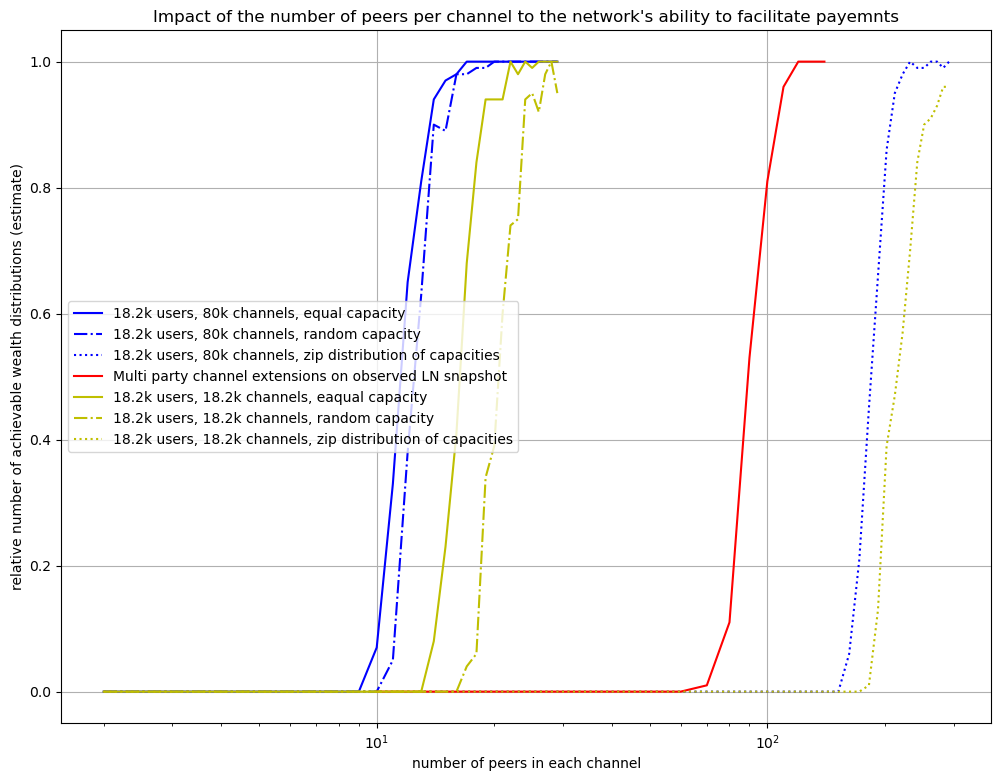

In [75]:
plt.figure(figsize=(12,9))
plt.title("Impact of the number of peers per channel to the network's ability to facilitate payemnts")

plt.plot(party_sizes,volumes, "b-",label="18.2k users, 80k channels, equal capacity")
plt.plot(party_sizes1,volumes1,"b-.", label="18.2k users, 80k channels, random capacity")
plt.plot(party_sizes5,volumes5,"b:", label="18.2k users, 80k channels, zip distribution of capacities")

plt.plot(party_sizes_ln, volumes_ln,"r", label="Multi party channel extensions on observed LN snapshot")

plt.plot(party_sizes3,volumes3, "y-", label="18.2k users, 18.2k channels, eaqual capacity")
plt.plot(party_sizes2,volumes2, "y-.",label="18.2k users, 18.2k channels, random capacity")
plt.plot(party_sizes4,volumes4,"y:", label="18.2k users, 18.2k channels, zip distribution of capacities")

plt.xscale("log")
plt.grid()
plt.xlabel("number of peers in each channel")
plt.ylabel("relative number of achievable wealth distributions (estimate)")
plt.legend()
plt.show()

## Conclusions

We have been able to model the set of possible wealth distributions in a (multiparty) payment channel network as a sub polytope of the possible wealth distributionis of the bitcoin network. Through Monte Carlo Simulations we are able to quantify the relative volume of the polytope defined through the topoology of (multiparty) payment channel network. In particular the larger the volume the more payments can be facilitated without requiring additional on chain transactions to manage liquidity.

We were able to see that for two party channels most wealth distributions are impossible even if the network topology is a fully connected graph. Note that if we had enough on chain capacity to maintain a fully connected network we wouldn´t need a payment channel network to begin with. Furthermore we could empirically demonstrate that even in this topology the number of achievable wealth distributions shrinks exponentially with the number of peers. The consequence seems to be that 2-party channels are impracticle to become highly reliable and be able to gurantee that $99.9999\%$ of payments are at least theoretically possible without running violating the constraints coming from the channels. 

Furthermore the constraints of the half spaces describing $2$-party payment channels are weakened drastically if we allow for multi party channels. We can show that with the same number of channels the number of possible wealth distributions converges quickly to $100\%$ if we increase the number of members of the multiparty channels. 

In particular when taking a snapshot of the Lighting Network and testing $100k$ wealth distributions that are possible with the allocated liquidity we didn´t have a single wealth distribution that was achievable within the network topology. If on the other hand we created the same number of $120$-party channels almost 100% of the tested wealth distributions where achievable in the multiparty channel network. 

We thus believe that constraining liquidity to just two peers ist too heavy of a constraint. Instead having multiparties of about one hundred peer, that may not require too much on chain space to resolve in the case of disagreement or failure of nodes to communicate seem to be a much more desireable trade off than the current $2$-party channel design of the network. 

In particular we have strong evidence to believe that the liquidity problem of the $2$-party channel lightning network needs too many on chain transactions to be solved (as the volumes of the polytope becomes too small) and that the two-party channel design is the actual problem for the observed payment failures. 

**Disclaimer: multiparty channels and channel factories have been proposed earlier. This work just provides a systematical and quantifyable reasoneing that they might be necessary to implement for off-chain payment channel networks to achieve reasonable service level objectives**

## Future work
* (Hopefully) We give a (reasonable) lower bound of onchain transactions that are at least necessary to be able to achieve any wealth distribution with the given channel design.
* Define a routnig protocol for multi party channels / hypergraphs
* Define a communication / coordination protocol such that peers can find reasonable parties
* Find a protocol for timeout trees / channel factories that minimizes interactivity to update states and on chhain bandwidth in case of communication failures. 